In [184]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


# Lab-2

Name: Purusharth Malik

Registration No.: 2348542

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

### Loading and preprocessing the data

In [276]:
train_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')
test_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')

print(train_data.shape)
print(test_data.shape)

(1296675, 23)
(555719, 23)


In [277]:
train_data.drop('Unnamed: 0', axis=1, inplace=True)
test_data.drop('Unnamed: 0', axis=1, inplace=True)

In [278]:
test_data.dtypes

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [279]:
train_data.head(1)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0


### Encoding and scaling variables

In [281]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Encode categorical variables
encoder = OneHotEncoder(drop='first')
categorical_cols = ['gender', 'category', 'state']
encoded_train_features = encoder.fit_transform(train_data[categorical_cols]).toarray()
encoded_test_features = encoder.transform(test_data[categorical_cols]).toarray()

# Feature scaling
scaler = StandardScaler()
numerical_cols = ['amt', 'lat', 'long','city_pop', 'unix_time', 'merch_lat', 'merch_long']
scaled_train_features = scaler.fit_transform(train_data[numerical_cols])
scaled_test_features = scaler.transform(test_data[numerical_cols])

# Concatenate encoded and scaled features for both train and test data
final_train_features = pd.concat([pd.DataFrame(encoded_train_features), pd.DataFrame(scaled_train_features)], axis=1)
final_test_features = pd.concat([pd.DataFrame(encoded_test_features), pd.DataFrame(scaled_test_features)], axis=1)

# Define target variables
y_train = train_data['is_fraud']
y_test = test_data['is_fraud']

In [298]:
y_train.value_counts(normalize=True)

is_fraud
0    0.99614
1    0.00386
Name: proportion, dtype: float64

### Generating synthetic data to deal with class imbalance using SMOTE

In [ ]:
# Generating synthetic data to balance the imbalanced dataset
smote = SMOTE(random_state=42)

X_test = final_test_features
X_train, y_train = smote.fit_resample(final_train_features, y_train)

X_shuffled, y_shuffled = shuffle(X_train, y_train, random_state=42)

# Taking out a sample of data to train model quickly
X_shuffled, y_shuffled = X_shuffled[:20000], y_shuffled[:20000]
X_train, X_val, y_train, y_val = train_test_split(X_shuffled, y_shuffled, test_size=0.5)

In [282]:
y_train.value_counts(normalize=True)

is_fraud
0    0.5048
1    0.4952
Name: proportion, dtype: float64

### Creating a Multi-Layer Perceptron

In [283]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [284]:
X_train.shape

(10000, 71)

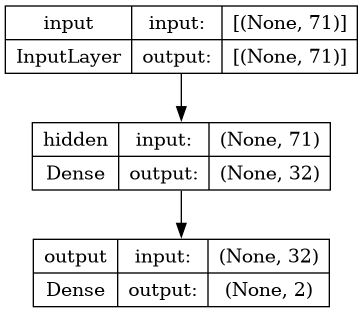

In [285]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model

# Creating the layers
input_layer = Input(shape=(71,), name='input')
hidden = Dense(32, name='hidden', activation=tf.nn.relu)(input_layer)
output = Dense(2, name='output', activation=tf.nn.sigmoid)(hidden)

# Initializing the model
model = Model(inputs=input_layer, outputs=output)

# Plotting the model
plot_model(model, show_layer_names=True, show_shapes=True)

In [286]:
# Looking at model summary
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 71)]              0         
                                                                 
 hidden (Dense)              (None, 32)                2304      
                                                                 
 output (Dense)              (None, 2)                 66        
                                                                 
Total params: 2370 (9.26 KB)
Trainable params: 2370 (9.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Creating a MLP using SGD with momentum as the optimizer

In [287]:
# Compiling the model
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.SGD(momentum=0.9),
              metrics=tf.keras.metrics.categorical_accuracy)

# Creating EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)

# Training the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    callbacks=early_stopping)

Epoch 1/100
313/313 [==============================] - 2s 5ms/step - loss: 0.4263 - categorical_accuracy: 0.8465 - val_loss: 0.3988 - val_categorical_accuracy: 0.8578
Epoch 2/100
313/313 [==============================] - 1s 5ms/step - loss: 0.3667 - categorical_accuracy: 0.8655 - val_loss: 0.3761 - val_categorical_accuracy: 0.8577
Epoch 3/100
313/313 [==============================] - 1s 5ms/step - loss: 0.3452 - categorical_accuracy: 0.8655 - val_loss: 0.3583 - val_categorical_accuracy: 0.8522
Epoch 4/100
313/313 [==============================] - 1s 4ms/step - loss: 0.3280 - categorical_accuracy: 0.8596 - val_loss: 0.3441 - val_categorical_accuracy: 0.8520
Epoch 5/100
313/313 [==============================] - 1s 4ms/step - loss: 0.3131 - categorical_accuracy: 0.8643 - val_loss: 0.3283 - val_categorical_accuracy: 0.8566
Epoch 6/100
313/313 [==============================] - 1s 5ms/step - loss: 0.2986 - categorical_accuracy: 0.8722 - val_loss: 0.3130 - val_categorical_accuracy: 0.863

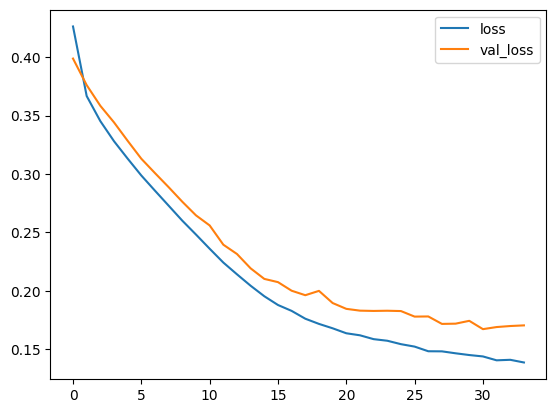

In [288]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### Creating a MLP using Adam as the optimizer

In [289]:
# Creating the layers
input_layer = Input(shape=(71,), name='input')
hidden = Dense(32, name='hidden', activation=tf.nn.relu)(input_layer)
output = Dense(2, name='output', activation=tf.nn.sigmoid)(hidden)

# Initializing the model
model = Model(inputs=input_layer, outputs=output)

# Compiling the model
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.AdamW(),
              metrics=tf.keras.metrics.categorical_accuracy)

# Training the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    callbacks=early_stopping)

Epoch 1/100
313/313 [==============================] - 2s 5ms/step - loss: 0.4840 - categorical_accuracy: 0.8073 - val_loss: 0.3966 - val_categorical_accuracy: 0.8431
Epoch 2/100
313/313 [==============================] - 1s 5ms/step - loss: 0.3540 - categorical_accuracy: 0.8477 - val_loss: 0.3618 - val_categorical_accuracy: 0.8328
Epoch 3/100
313/313 [==============================] - 1s 5ms/step - loss: 0.3278 - categorical_accuracy: 0.8459 - val_loss: 0.3403 - val_categorical_accuracy: 0.8385
Epoch 4/100
313/313 [==============================] - 1s 5ms/step - loss: 0.3079 - categorical_accuracy: 0.8577 - val_loss: 0.3209 - val_categorical_accuracy: 0.8523
Epoch 5/100
313/313 [==============================] - 1s 5ms/step - loss: 0.2856 - categorical_accuracy: 0.8758 - val_loss: 0.2988 - val_categorical_accuracy: 0.8672
Epoch 6/100
313/313 [==============================] - 1s 5ms/step - loss: 0.2630 - categorical_accuracy: 0.8898 - val_loss: 0.2762 - val_categorical_accuracy: 0.886

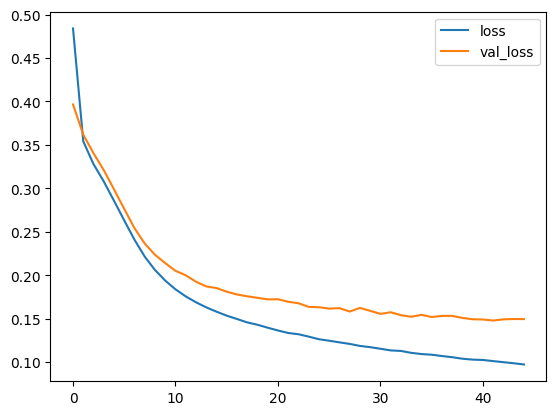

In [290]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### Evaluating the model

In [291]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

y_pred = model.predict(X_test)

y_pred = [np.argmax(i) for i in y_pred]

print(classification_report(y_test, y_pred))

17367/17367 [==============================] - 25s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    553574
           1       0.06      0.87      0.11      2145

    accuracy                           0.94    555719
   macro avg       0.53      0.91      0.54    555719
weighted avg       1.00      0.94      0.97    555719



In [296]:
from sklearn.metrics import precision_score, recall_score

print(f'Precision Score: {precision_score(y_test, y_pred)}\nRecall Score: {recall_score(y_test, y_pred)}')
print(f'ROC AUC score: {roc_auc_score(y_test, y_pred)}\nAccuracy: {accuracy_score(y_test, y_pred)}')

Precision Score: 0.05642100148795967
Recall Score: 0.8662004662004662
ROC AUC score: 0.9050344279865538
Accuracy: 0.9435686021172571


Obviously, the precision score is low but that is because the number of misclassified "legal" transactions is naturally greater than the correctly classified "fraud" transactions (this is because of the class imbalance).

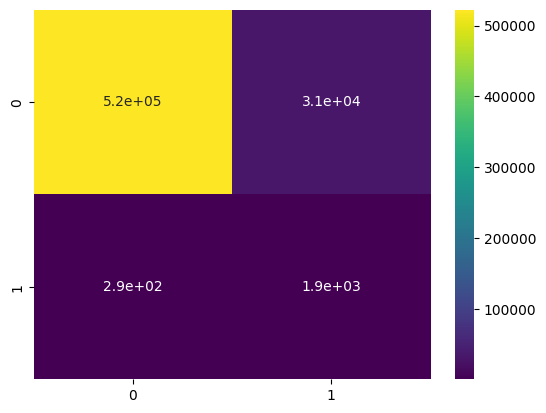

In [293]:
sns.heatmap(confusion_matrix(y_test, y_pred),
            cmap='viridis',
            annot=True)
plt.show()

Clearly, the model does a good enough job at recognizing "fraud" transactions as is evident by the ROC-AUC score.

# End